Source:
- https://github.com/abhinavsagar/breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb

## Libraries

In [17]:
import json
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import gc
import itertools

from PIL import Image
from functools import partial
from sklearn import metrics
from collections import Counter
from keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

In [18]:
import numpy as np
import json
import utils_nn_eval
import gc
import pandas
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [19]:
figure_path = 'D:/Medical_Imaging/Medical_Imaging_Elias/Figures/'

## Load Images

### Ground Truth Images

In [20]:
benign = utils_nn_eval.get_all_images('gt_benign')
malignant = utils_nn_eval.get_all_images('gt_malignant')

In [21]:
print(len(benign))
print(len(malignant))

625
1370


## Create Split

In [22]:
X_test, Y_test, x_train, x_val, y_train, y_val = utils_nn_eval.create_split(benign, malignant)

## Display Images

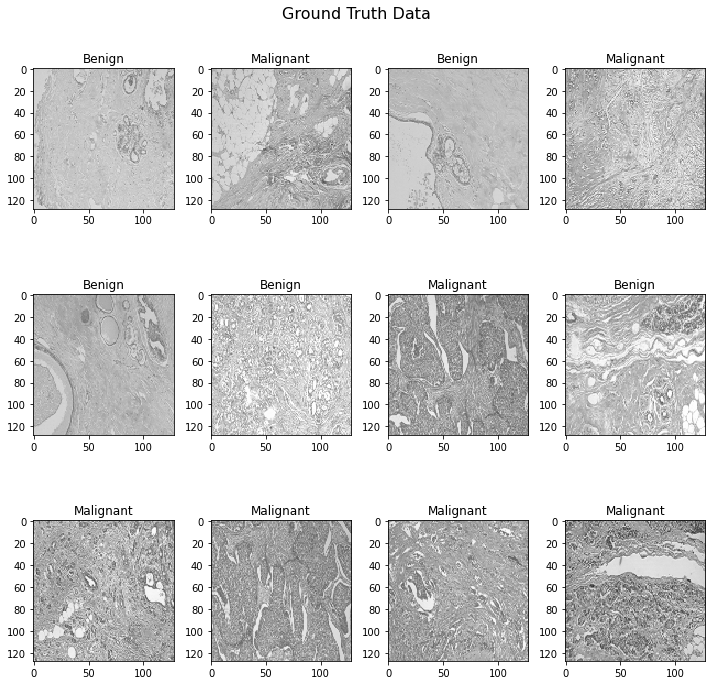

In [23]:
utils_nn_eval.display_images(x_train, y_train, "Ground Truth Data")

## Data Generator

In [24]:
train_generator = utils_nn_eval.create_train_generator()

## Model Creation

In [25]:
def build_model(backbone, lr = 1e-4):

    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation = 'softmax'))
    
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate = lr),
        metrics = ['accuracy']
    )
    
    return model

In [26]:
K.clear_session()
gc.collect()

shape = (128, 128, 3)

resnet = DenseNet201(
                        weights = 'imagenet',
                        include_top = False,
                        input_shape = shape
                    )

model = build_model(resnet , lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

## Training & Evaluation

In [27]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath = "densenet_new_local.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [28]:
history = model.fit(

    train_generator.flow(x_train, y_train, batch_size = 16),
    steps_per_epoch=x_train.shape[0] / 16,
    epochs=2,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/2
80/79 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.5925
Epoch 1: val_accuracy improved from -inf to 0.51562, saving model to densenet_new_local.hdf5
79/79 [==============================] - 273s 3s/step - loss: 0.7128 - accuracy: 0.5925 - val_loss: 0.7075 - val_accuracy: 0.5156 - lr: 1.0000e-04
Epoch 2/2
80/79 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.7171
Epoch 2: val_accuracy improved from 0.51562 to 0.79688, saving model to densenet_new_local.hdf5
79/79 [==============================] - 245s 3s/step - loss: 0.5940 - accuracy: 0.7171 - val_loss: 0.4999 - val_accuracy: 0.7969 - lr: 1.0000e-04


In [29]:
with open('history.json', 'w') as f:
    
    json.dump(str(history.history), f)

## Prediction on Ground Truth Data

In [30]:
filepath_model = "./densenet_new_local.hdf5"
model.load_weights(filepath_model)

In [31]:
Y_val_pred = model.predict(x_val)

10/10 [==============================] - 17s 1s/step


In [32]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.796875

In [15]:
Y_pred = model.predict(X_test)

13/13 [==============================] - 18s 1s/step


In [16]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):

    preds = model.predict_generator(train_generator.flow(X_test, batch_size = 16, shuffle = False),
                                            steps = len(X_test)/16)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis = 0)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\elias\AppData\Local\Temp/ipykernel_6020/349739191.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model_gt.predict_generator(train_generator.flow(X_test, batch_size = 16, shuffle = False),
100%|██████████| 10/10 [03:19<00:00, 19.94s/it]


## Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[120   5]
 [264  10]]


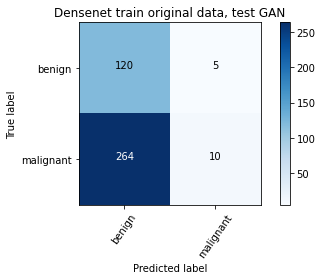

In [18]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Densenet train original data, test GAN')

Confusion matrix, without normalization
[[103  22]
 [245  29]]


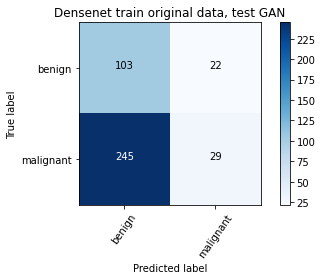

In [19]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Densenet train original data, test GAN')

## Classification Report

In [20]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.31      0.96      0.47       125
           1       0.67      0.04      0.07       274

    accuracy                           0.33       399
   macro avg       0.49      0.50      0.27       399
weighted avg       0.56      0.33      0.20       399



In [21]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.30      0.82      0.44       125
           1       0.57      0.11      0.18       274

    accuracy                           0.33       399
   macro avg       0.43      0.46      0.31       399
weighted avg       0.48      0.33      0.26       399



In [22]:
report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), output_dict = True)
df = pd.DataFrame(report).transpose()
df.to_csv(figure_path + "classification_report_trained_original_test_gan.csv", index = False)

## ROC and AUC

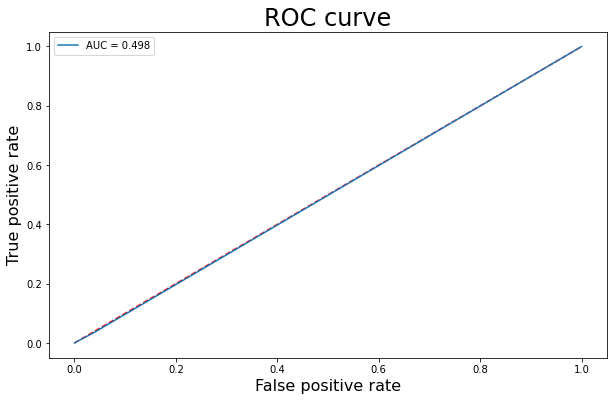

In [23]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve


roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.rcParams["figure.figsize"] = [10, 6]
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 16)
plt.title('ROC curve', fontsize = 24)
plt.legend(loc='best')

plt.savefig(figure_path + 'roc_auc_score_trained_original_test_gan.png')

plt.show()
plt.close()

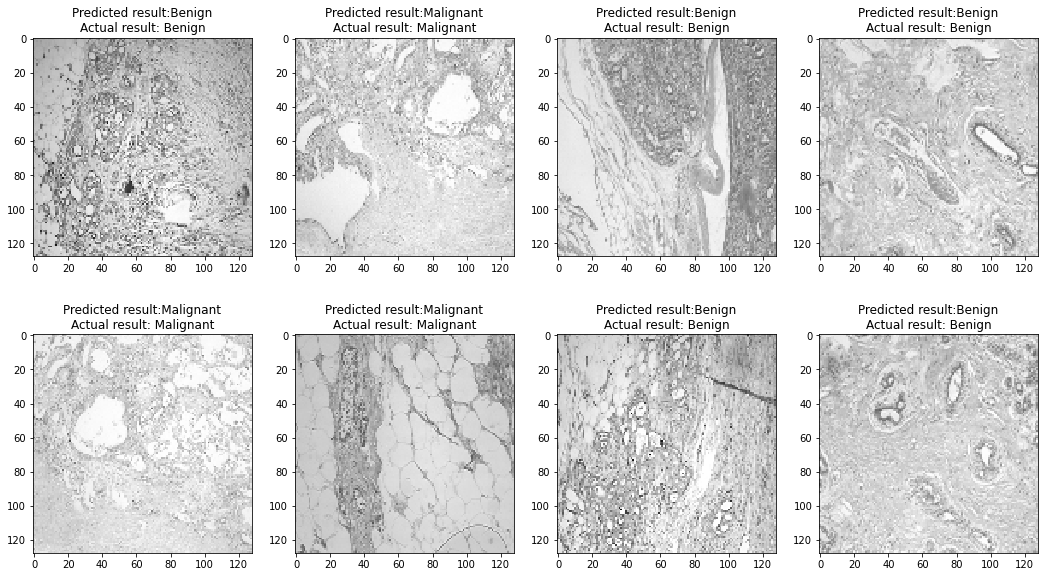

In [24]:
i = 0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):

    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):

        prop_class.append(i)

    if(len(prop_class)==8):

        break

i = 0

for i in range(len(Y_test)):

    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):

        mis_class.append(i)

    if(len(mis_class)==8):

        break

# # Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize = (18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    
    if namecode==0:
    
        return "Benign"
    
    else:
    
        return "Malignant"
    
for i in range(len(prop_class)):
    
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
    
plt.show()